In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
seed_value = 42
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)  # For full reproducibility
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# --- Improved Plot Settings ---
plt.close('all')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12,
    'figure.dpi': 100,
    'figure.figsize': (6, 4),
    'axes.grid': True,
    'grid.alpha': 0.5,
    'lines.linewidth': 2,
    'savefig.bbox': 'tight',
    'savefig.dpi': 300
})

In [2]:
pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import deepxde as dde
#from deepxde.backend import tf
import tensorflow as tf
tf.random.set_seed(seed_value)

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


# Positive

Compiling model...
Building feed-forward neural network...
'build' took 0.140729 s

'compile' took 3.082466 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.03e+08, 1.60e-02, 2.81e+08]    [2.05e+08, 1.60e-02, 2.81e+08]    []  
1000      [2.49e+07, 2.72e-02, 2.45e+06]    [2.48e+07, 2.72e-02, 2.45e+06]    []  
2000      [4.51e+06, 2.79e-02, 2.74e+05]    [4.49e+06, 2.79e-02, 2.74e+05]    []  
3000      [3.31e+05, 2.79e-02, 1.41e+04]    [3.32e+05, 2.79e-02, 1.41e+04]    []  
4000      [6.58e+04, 2.79e-02, 1.46e+02]    [6.45e+04, 2.79e-02, 1.46e+02]    []  
5000      [6.20e+04, 2.79e-02, 1.16e+01]    [6.03e+04, 2.79e-02, 1.16e+01]    []  
6000      [5.83e+04, 2.79e-02, 9.83e+00]    [5.68e+04, 2.79e-02, 9.83e+00]    []  
7000      [5.29e+04, 2.79e-02, 8.71e+00]    [5.16e+04, 2.79e-02, 8.71e+00]    []  
8000      [4.54e+04, 2.79e-02, 7.13e+00]    [4.43e+04, 2.79e-02, 7.13e+00]    []  
9000      [3.59e+04, 2.78e-02, 5.

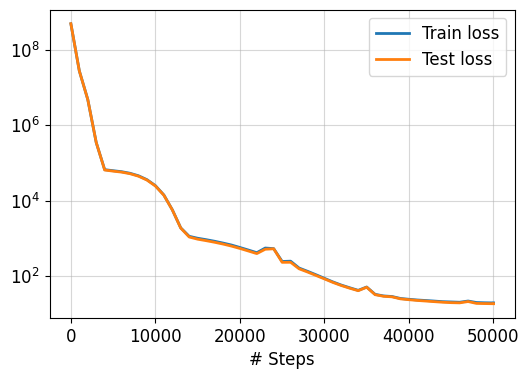

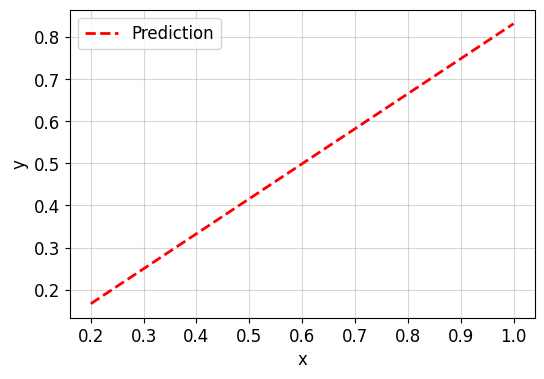

Saving loss history to /kaggle/working/loss.dat ...
Saving training data to /kaggle/working/train.dat ...
Saving test data to /kaggle/working/test.dat ...


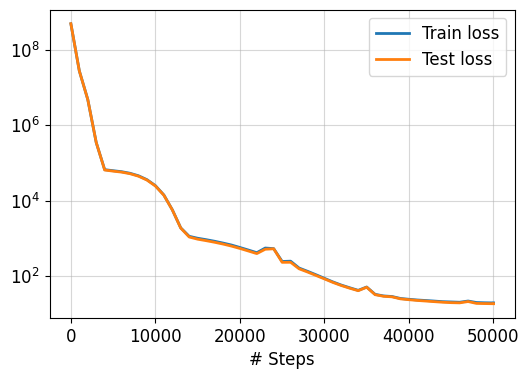

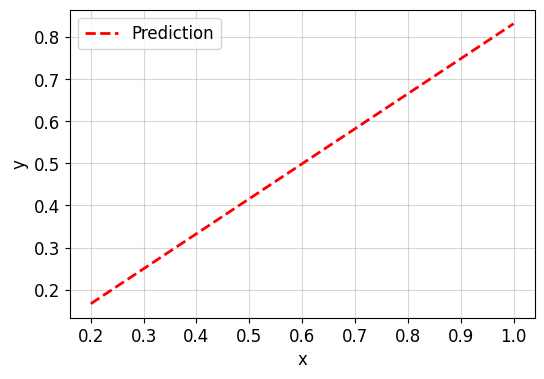

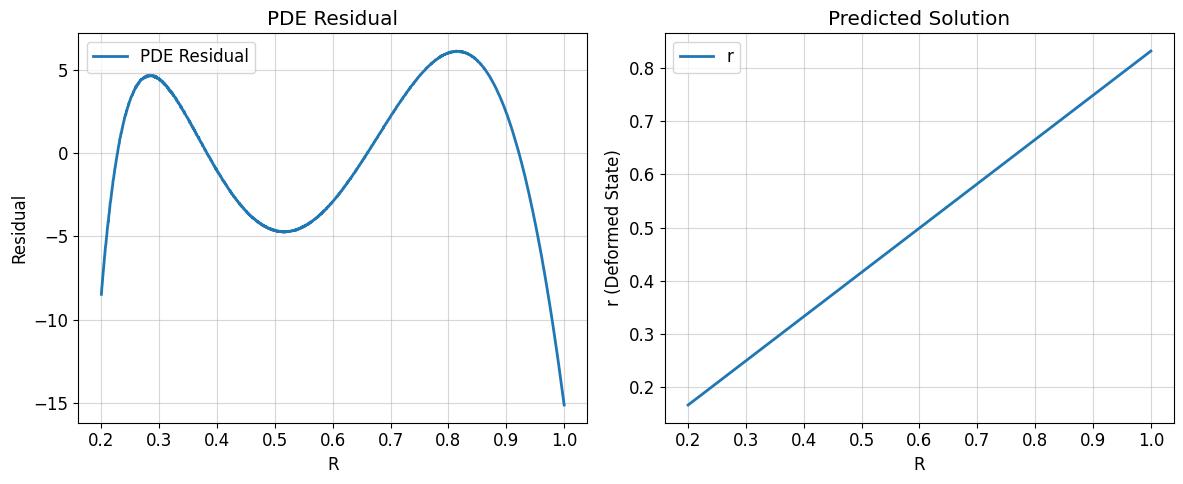

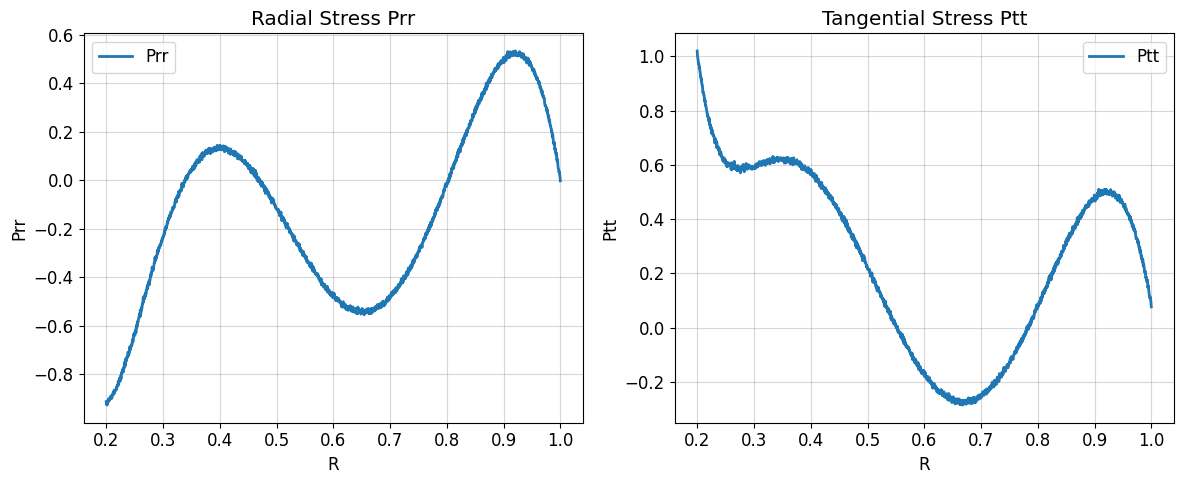

NaNs in PDE residual: False
NaNs in predicted solution: False
NaNs in Prr: False
NaNs in Ptt: False


In [4]:
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
dde.config.set_random_seed(42)

# Define Prr (radial stress) with improved stability
def Prr(R, r):
    # Ensure r is non-negative
    r = tf.abs(r)  # Take absolute value to enforce r >= 0
    r_R = r  # Deformed state
    R_2 = tf.square(R)
    dr_dR = dde.grad.jacobian(r, R, i=0, j=0)
    r_R_2 = tf.square(r_R)
    dr_dR_2 = tf.square(dr_dR)

    # Common term with safe division
    term_common = tf.math.divide_no_nan(dr_dR_2 * r_R_2, R_2)
    term_common_pow_4_3 = tf.math.pow(term_common, 4.0 / 3.0)
    term_common_pow_1_3 = tf.math.pow(term_common, 1.0 / 3.0)
    term_common_pow_1_2 = tf.math.pow(term_common, 1.0 / 2.0)

    # Term 1
    term1_numerator = (4.0**(2.0/3.0)) * (dr_dR_2 + tf.math.divide_no_nan(r_R_2, R_2) + 4) * dr_dR * r_R_2
    term1_denominator = 6.0 * R_2 * term_common_pow_4_3
    term1_rr = tf.math.divide_no_nan(term1_numerator, term1_denominator)

    # Term 2
    term2_numerator = (4.0**(2.0/3.0)) * dr_dR
    term2_denominator = 2.0 * term_common_pow_1_3
    term2_rr = tf.math.divide_no_nan(term2_numerator, term2_denominator)

    # Term 3
    term3_numerator = (2.0 * term_common_pow_1_2 - 1.0) * 2.0 * dr_dR * r_R_2
    term3_denominator = term_common_pow_1_2 * R_2
    term3_rr = tf.math.divide_no_nan(term3_numerator, term3_denominator)

    Prr_final = 1500.0 * (-term1_rr + term2_rr) + 5000.0 * term3_rr
    return tf.debugging.check_numerics(Prr_final, "NaN in Prr")

# Define Ptt (tangential stress) similarly
def Ptt(R, r):
    # Ensure r is non-negative
    r = tf.abs(r)  # Take absolute value to enforce r >= 0
    r_R = r
    R_2 = tf.square(R)
    dr_dR = dde.grad.jacobian(r, R, i=0, j=0)
    r_R_2 = tf.square(r_R)
    dr_dR_2 = tf.square(dr_dR)

    term_common = tf.math.divide_no_nan(dr_dR_2 * r_R_2, R_2)
    term_common_pow_4_3 = tf.math.pow(term_common, 4.0 / 3.0)
    term_common_pow_1_3 = tf.math.pow(term_common, 1.0 / 3.0)
    term_common_pow_1_2 = tf.math.pow(term_common, 1.0 / 2.0)
    
    term1_numerator = (4.0**(2.0/3.0)) * (dr_dR_2 + tf.math.divide_no_nan(r_R_2, R_2) + 4) * dr_dR_2 * r_R
    term1_denominator = 6.0 * R * term_common_pow_4_3
    term1_tt = tf.math.divide_no_nan(term1_numerator, term1_denominator)

    term2_numerator = (4.0**(2.0/3.0)) * r_R
    term2_denominator = 2.0 * R * term_common_pow_1_3
    term2_tt = tf.math.divide_no_nan(term2_numerator, term2_denominator)

    term3_numerator = (2.0 * term_common_pow_1_2 - 1.0) * 2.0 * dr_dR_2 * r_R
    term3_denominator = term_common_pow_1_2 * R
    term3_tt = tf.math.divide_no_nan(term3_numerator, term3_denominator)
    
    Ptt_final = 1500.0 * (-term1_tt + term2_tt) + 5000.0 * term3_tt
    return tf.debugging.check_numerics(Ptt_final, "NaN in Ptt")

# Define PDE with scaling
def pde(R, r):
    # Ensure r is non-negative
    r = tf.abs(r)  # Take absolute value to enforce r >= 0
    prr = Prr(R, r)
    ptt = Ptt(R, r)
    dprr_dR = dde.grad.jacobian(prr, R, i=0, j=0)
    residual = dprr_dR + tf.math.divide_no_nan(prr, R) - tf.math.divide_no_nan(ptt, R)
    return residual

# Boundary condition functions
def boundary_left(R, on_boundary):
    return on_boundary and dde.utils.isclose(R[0], 0.2)

def boundary_right(R, on_boundary):
    return on_boundary and dde.utils.isclose(R[0], 1)

# Geometry
geom = dde.geometry.Interval(0.2, 1)

# Boundary conditions
bc1 = dde.icbc.DirichletBC(geom, lambda x: [0.0], boundary_left)
bc2 = dde.icbc.OperatorBC(geom, lambda inputs, outputs, X: Prr(inputs, tf.abs(outputs)), boundary_right)  # Ensure r is non-negative

# Logarithmic training points
x_log = np.logspace(-3, 0, 200).reshape(-1, 1)

# PDE data with anchors
data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2],
    num_domain=200,
    num_boundary=2,
    #anchors=x_log,
    num_test=200
)

# Neural network (revert to original, no need for special activation)
net = dde.nn.FNN([1] + [100] * 6 + [1], "tanh", "Glorot uniform")

# Model
model = dde.Model(data, net)

# Compile with Adam
model.compile("adam", lr=3e-6)  # Larger lr since PDE is scaled

# Early stopping callback
early_stopping = dde.callbacks.EarlyStopping(
    monitor="loss_train",  # Monitor training loss
    min_delta=1e-1,
    patience=3000
)

# Train with Adam
losshistory_adam, train_state_adam = model.train(
    iterations= 50000,
    callbacks=[early_stopping]
)

# Switch to L-BFGS
model.compile("L-BFGS")
losshistory_lbfgs, train_state_lbfgs = model.train()

# Save plots
dde.saveplot(losshistory_adam, train_state_adam, issave=True, isplot=True)
dde.saveplot(losshistory_lbfgs, train_state_lbfgs, issave=True, isplot=True)

# Post-training analysis
x = geom.uniform_points(2000, True)
y_pred = model.predict(x)  # Predicted r (may be negative, but we'll take abs later for plotting)
y_pred_positive = np.abs(y_pred)  # Use np.abs since y_pred should already be a NumPy array from model.predict
y_pde = model.predict(x, operator=pde)

# Plot PDE residual and solution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(x, y_pde, label="PDE Residual")
axes[0].set_xlabel("R")
axes[0].set_ylabel("Residual")
axes[0].set_title("PDE Residual")
axes[0].legend()

axes[1].plot(x, y_pred_positive, label="r")
axes[1].set_xlabel("R")
axes[1].set_ylabel("r (Deformed State)")
axes[1].set_title("Predicted Solution")
axes[1].legend()
plt.tight_layout()
plt.show()

# Plot Prr and Ptt
# No need for .numpy() since model.predict already returns NumPy arrays
Prr_values = model.predict(x, operator=lambda R, r: Prr(R, tf.abs(r)))
Ptt_values = model.predict(x, operator=lambda R, r: Ptt(R, tf.abs(r)))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(x, Prr_values, label="Prr")
axes[0].set_xlabel("R")
axes[0].set_ylabel("Prr")
axes[0].set_title("Radial Stress Prr")
axes[0].legend()

axes[1].plot(x, Ptt_values, label="Ptt")
axes[1].set_xlabel("R")
axes[1].set_ylabel("Ptt")
axes[1].set_title("Tangential Stress Ptt")
axes[1].legend()
plt.tight_layout()
plt.show()

# Check for NaNs
print(f"NaNs in PDE residual: {np.isnan(y_pde).any()}")
print(f"NaNs in predicted solution: {np.isnan(y_pred).any()}")
print(f"NaNs in Prr: {np.isnan(Prr_values).any()}")
print(f"NaNs in Ptt: {np.isnan(Ptt_values).any()}")